<a href="https://colab.research.google.com/github/gavincapriola/PyTorch-Deep-Learning-and-Artificial-Intelligence/blob/main/Natural%20Language%20Processing%20(NLP)/Custom_PyTorch_Text_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [3]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [7]:
df_train, df_test = train_test_split(df, test_size=0.33)
df_train.shape, df_test.shape

((3733, 3), (1839, 3))

In [8]:
idx = 1
word2idx = {'<PAD>': 0}

In [9]:
for i, row in df_train.iterrows():
    tokens = row['data'].lower().split() #simple tokenization
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = idx
            idx += 1

In [10]:
word2idx

{'<PAD>': 0,
 'my': 1,
 'life': 2,
 'means': 3,
 'a': 4,
 'lot': 5,
 'to': 6,
 'me,': 7,
 'not': 8,
 'because': 9,
 'i': 10,
 'love': 11,
 'life,': 12,
 'but': 13,
 'the': 14,
 'people': 15,
 'in': 16,
 'world': 17,
 'calls': 18,
 'them': 19,
 'friends,': 20,
 'call': 21,
 'world:-)..': 22,
 'ge:-)..': 23,
 'miss': 24,
 'ya,': 25,
 'need': 26,
 'want': 27,
 'ya.': 28,
 'you': 29,
 'know,': 30,
 'wot': 31,
 'wear.': 32,
 't': 33,
 'shirts,': 34,
 'jumpers,': 35,
 'hat,': 36,
 'belt,': 37,
 'is': 38,
 'all': 39,
 'we': 40,
 'know.': 41,
 'r': 42,
 'at': 43,
 'cribbs': 44,
 'goal!': 45,
 'arsenal': 46,
 '4': 47,
 '(henry,': 48,
 '7': 49,
 'v': 50,
 'liverpool': 51,
 '2': 52,
 'henry': 53,
 'scores': 54,
 'with': 55,
 'simple': 56,
 'shot': 57,
 'from': 58,
 '6': 59,
 'yards': 60,
 'pass': 61,
 'by': 62,
 'bergkamp': 63,
 'give': 64,
 'goal': 65,
 'margin': 66,
 'after': 67,
 '78': 68,
 'mins.': 69,
 'watching': 70,
 'tv': 71,
 'lor...': 72,
 'canåõt': 73,
 'wait': 74,
 'for': 75,
 'cornwa

In [11]:
word2idx.__len__()

10588

In [12]:
train_sentences_as_int = []
for i, row in df_train.iterrows():
    tokens = row['data'].lower().split()
    sentence_as_int = [word2idx[token] for token in tokens]
    train_sentences_as_int.append(sentence_as_int)

test_sentences_as_int = []
for i, row in df_test.iterrows():
    tokens = row['data'].lower().split()
    sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
    test_sentences_as_int.append(sentence_as_int)

In [13]:
train_sentences_as_int.__len__(), test_sentences_as_int.__len__()

(3733, 1839)

In [14]:
def data_generator(X, y, batch_size=32):
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(y.__len__() / batch_size))
    for i in range(n_batches):
        end = min((i+1) * batch_size, y.__len__())

        X_batch = X[i * batch_size:end]
        y_batch = y[i * batch_size:end]

        max_len = np.max([x.__len__() for x in X_batch])
        for j in range(X_batch.__len__()):
            x = X_batch[j]
            pad = [0] * (max_len - x.__len__())
            X_batch[j] = pad + x

        # convert to tensor
        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        yield X_batch, y_batch

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
embed = nn.Embedding(word2idx.__len__(), 20)
for inputs, targets in data_generator(train_sentences_as_int, df_train.b_labels):
    out = embed(inputs)
    print('Input shape:', inputs.shape)
    print('Output shape:', out.shape)
    break

Input shape: torch.Size([32, 36])
Output shape: torch.Size([32, 36, 20])


In [17]:
class CNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_outputs):
        super(CNN, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.K = n_outputs

        self.embed = nn.Embedding(self.V, self.D)
        
        self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(64, 128, 3, padding=1)

        self.fc = nn.Linear(128, self.K)

    def forward(self, X):
        out = self.embed(X)

        out = out.permute(0, 2, 1)
        out = self.conv1(out)
        out = F.relu(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = F.relu(out)

        out = out.permute(0, 2, 1)

        out, _ = torch.max(out, 1)

        out = self.fc(out)
        return out

In [18]:
model = CNN(word2idx.__len__(), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(10588, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [19]:
# loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [20]:
train_gen = lambda: data_generator(train_sentences_as_int, df_train.b_labels)
test_gen = lambda: data_generator(test_sentences_as_int, df_test.b_labels)

In [21]:
def batch_gd(model, criterion, optimizer, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.datetime.now()
        train_loss = []

        for inputs, targets in train_gen():
            targets = targets.view(-1, 1).float()
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        train_loss = np.mean(train_loss)
        test_loss = []

        for inputs, targets in test_gen():
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.view(-1, 1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())

        test_loss = np.mean(test_loss)
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.datetime.now() - t0

        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")

    return train_losses, test_losses

In [22]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, 8)

Epoch 1/8, Train Loss: 0.3893, Test Loss: 0.3120, Duration: 0:00:08.645819
Epoch 2/8, Train Loss: 0.2362, Test Loss: 0.2261, Duration: 0:00:00.481425
Epoch 3/8, Train Loss: 0.1512, Test Loss: 0.1392, Duration: 0:00:00.480306
Epoch 4/8, Train Loss: 0.1043, Test Loss: 0.1120, Duration: 0:00:00.475950
Epoch 5/8, Train Loss: 0.0694, Test Loss: 0.1008, Duration: 0:00:00.484260
Epoch 6/8, Train Loss: 0.0544, Test Loss: 0.0948, Duration: 0:00:00.474198
Epoch 7/8, Train Loss: 0.0348, Test Loss: 0.0950, Duration: 0:00:00.467818
Epoch 8/8, Train Loss: 0.0248, Test Loss: 0.1388, Duration: 0:00:00.471959


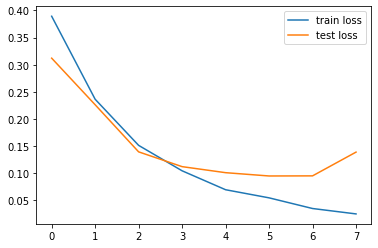

In [23]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [24]:
n_correct = 0.
n_total = 0.

for inputs, targets in train_gen():
    targets = targets.view(-1, 1).float()
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model(inputs)
    predictions = (outputs > 0).float()

    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total
n_correct = 0.
n_total = 0.

for inputs, targets in test_gen():
    targets = targets.view(-1, 1).float()

    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)

    predictions = (outputs > 0).float()

    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9887, Test acc: 0.9690
